#### import libraries

In [103]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (silhouette_score, davies_bouldin_score, calinski_harabasz_score)

In [104]:
# Loading the data into the notebook
np.random.seed(42)
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Loading the data into a pandas dataframe
cancer_df = pd.DataFrame(cancer['data'], columns= cancer['feature_names'])
cancer_df['target'] = cancer['target']
cancer_temp = cancer_df.sample(frac=1)

In [105]:
x = cancer_df.drop(["target"],axis=1) 
y = cancer_df[['target']]

In [106]:
# Splitting Data into Training and Test sets 

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

##### K-Means

In [107]:
kmeans_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9)),   
    ("cluster", KMeans(n_clusters=3, random_state=42, n_init=10))
])


##### Hierarchical (Agglomerative) Clustering

In [108]:
hierarchical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9)),   
    ("cluster", AgglomerativeClustering(
        n_clusters=3,
        linkage="ward"
    ))
])

##### DBSCAN

In [109]:
dbscan_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9)), 
    ("cluster", DBSCAN(
        eps=0.5,
        min_samples=5
    ))
])

In [110]:
pipelines = {
    "KMeans": kmeans_pipeline,
    "Hierarchical": hierarchical_pipeline,
    "DBSCAN": dbscan_pipeline
}

results = []

for name, pipe in pipelines.items():
    print(f"\n {name} ")

    pipe.fit(x)   # X = feature matrix

    labels = pipe.named_steps["cluster"].labels_

    # DBSCAN may assign all points as noise
    if len(set(labels)) <= 1:
        print("Only one cluster (or noise). Skipping metrics.")
        continue

    silhouette = silhouette_score(x, labels)
    db_index = davies_bouldin_score(x, labels)
    ch_index = calinski_harabasz_score(x, labels)

    results.append({
        "Model": name,
        "Num_Clusters": len(set(labels)) - (1 if -1 in labels else 0),
        "Silhouette": silhouette,
        "Davies_Bouldin": db_index,
        "Calinski_Harabasz": ch_index
    })



 KMeans 

 Hierarchical 

 DBSCAN 
Only one cluster (or noise). Skipping metrics.


In [111]:
results_df = pd.DataFrame(results)
results_df


,Model,Num_Clusters,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,KMeans,3,0.229928,1.867479,619.895739
1,Hierarchical,3,0.311945,1.332078,533.924343


In [112]:
pca_loadings = {}

for name, pipe in fitted_models.items():
    pca = pipe.named_steps["pca"]

    loadings = pd.DataFrame(
        pca.components_.T,
        index=x.columns,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    pca_loadings[name] = loadings

pca_loadings["KMeans"].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
mean radius,0.218902,-0.233857,-0.008531,-0.041409,-0.037786,0.018741,-0.124088
mean texture,0.103725,-0.059706,0.064550,0.603050,0.049469,-0.032179,0.011400
mean perimeter,0.227537,-0.215181,-0.009314,-0.041983,-0.037375,0.017308,-0.114477
mean area,0.220995,-0.231077,0.028700,-0.053434,-0.010331,-0.001888,-0.051653
mean smoothness,0.142590,0.186113,-0.104292,-0.159383,0.365089,-0.286374,-0.140669


#### Cluster visualization (2D PCA)

In [113]:
models = {
    "K-Means": KMeans(n_clusters=3, random_state=42, n_init=10),
    "Hierarchical": AgglomerativeClustering(n_clusters=3, linkage="ward"),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
}

# Scale data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

cluster_labels = {}

for name, model in models.items():
    labels = model.fit_predict(x_scaled)
    cluster_labels[name] = labels


In [114]:
pca_2d = PCA(n_components=2, random_state=42)
x_pca_2d = pca_2d.fit_transform(x_scaled)


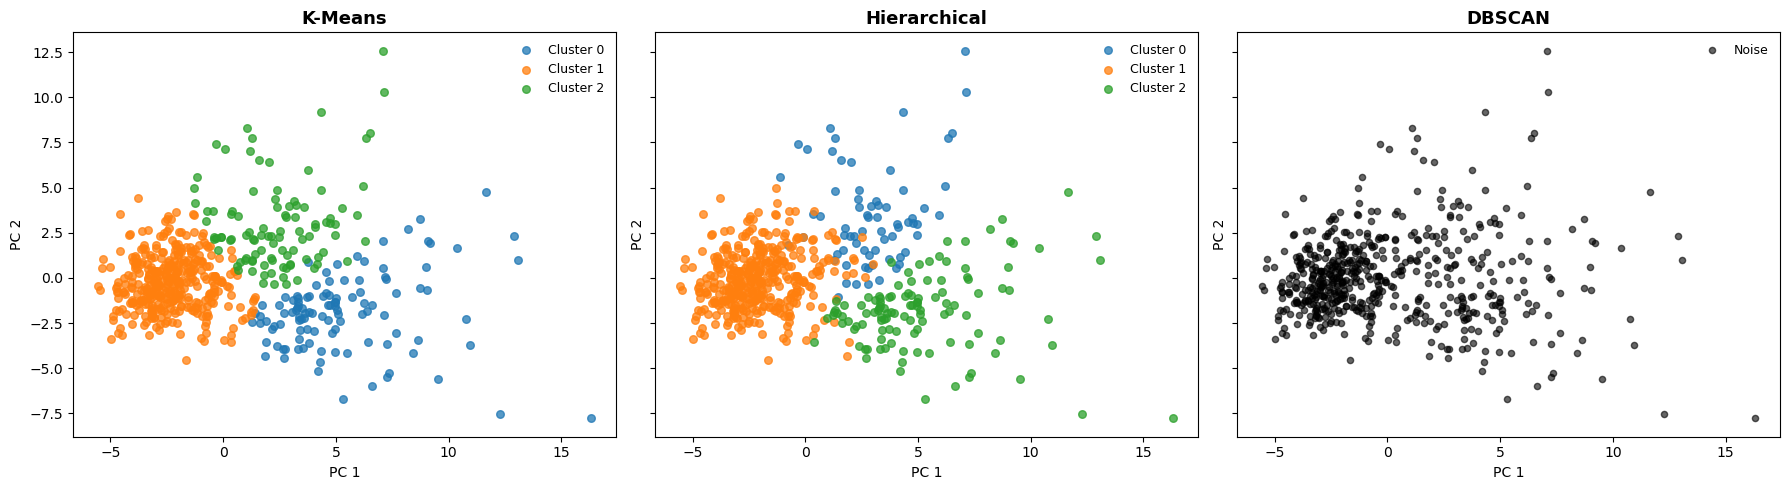

In [115]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    sharex=True,
    sharey=True
)

for ax, (name, labels) in zip(axes, cluster_labels.items()):

    unique_labels = np.unique(labels)

    for label in unique_labels:
        mask = labels == label

        # Noise points for DBSCAN
        if label == -1:
            ax.scatter(
                x_pca_2d[mask, 0],
                x_pca_2d[mask, 1],
                c="black",
                s=20,
                alpha=0.6,
                label="Noise"
            )
        else:
            ax.scatter(
                x_pca_2d[mask, 0],
                x_pca_2d[mask, 1],
                s=30,
                alpha=0.75,
                label=f"Cluster {label}"
            )

    ax.set_title(name, fontsize=13, fontweight="bold")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.legend(frameon=False, fontsize=9)

plt.tight_layout()
plt.show()


In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

In [117]:
# Fit all clustering pipelines
fitted_models = {}

for name, pipe in pipelines.items():
    pipe.fit(x)
    fitted_models[name] = pipe


In [118]:
pca_loadings = {}

for name, pipe in fitted_models.items():
    pca = pipe.named_steps["pca"]
    
    loadings = pd.DataFrame(
        pca.components_.T,
        index=x.columns,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
    
    pca_loadings[name] = loadings


In [119]:
pca_variance = {}

for name, pipe in fitted_models.items():
    pca = pipe.named_steps["pca"]
    
    pca_variance[name] = pd.DataFrame({
        "PC": [f"PC{i+1}" for i in range(pca.n_components_)],
        "Explained_Variance": pca.explained_variance_ratio_
    })


In [120]:
from sklearn.metrics import pairwise_distances

def cluster_feature_importance(X_scaled, labels):
    
    # Exclude noise for DBSCAN
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]
    
    if len(unique_labels) <= 1:
        # Cannot compute importance if only 1 cluster
        return np.zeros(X_scaled.shape[1])
    
    # Compute centroids per cluster
    centroids = np.array([
        X_scaled[labels == lab].mean(axis=0)
        for lab in unique_labels
    ])
    
    # Feature-wise separation: mean pairwise centroid distance
    importance = np.mean(pairwise_distances(centroids, metric="euclidean"), axis=0)
    
    return importance


In [121]:
feature_importance = {}

for name, pipe in fitted_models.items():
    scaler = pipe.named_steps["scaler"]
    pca = pipe.named_steps["pca"]
    labels = pipe.named_steps["cluster"].labels_
    
    # Skip models with 1 cluster only
    if len(np.unique(labels)) <= 1:
        continue
    
    X_scaled = scaler.transform(x)
    X_pca = pca.transform(X_scaled)
    
    imp = cluster_feature_importance(X_pca, labels)
    
    feature_importance[name] = pd.Series(
        imp,
        index=[f"PC{i+1}" for i in range(len(imp))]
    ).sort_values(ascending=False)

# Example
feature_importance["KMeans"]


PC3    4.558042
PC1    4.522100
PC2    3.862998
dtype: float64

##### Cluster importance

In [122]:
cluster_importance = {}

for name, pipe in fitted_models.items():
    scaler = pipe.named_steps["scaler"]
    pca = pipe.named_steps["pca"]
    labels = pipe.named_steps["cluster"].labels_

    if len(np.unique(labels)) <= 1:
        continue

    X_scaled = scaler.transform(x)
    X_pca = pca.transform(X_scaled)

    importance = cluster_feature_importance(X_pca, labels)

    cluster_importance[name] = pd.Series(
        importance,
        index=[f"PC{i+1}" for i in range(len(importance))]
    ).sort_values(ascending=False)

In [123]:
pca_strength = {}

for name, loadings in pca_loadings.items():
    pca_strength[name] = loadings.abs().mean(axis=0)

In [124]:
comparison_tables = {}

for name in cluster_importance.keys():
    df = pd.DataFrame({
        "Avg_Loading_Magnitude": pca_strength[name],
        "Cluster_Importance": cluster_importance[name]
    }).dropna()

    comparison_tables[name] = df

# Example
comparison_tables["KMeans"]


,Avg_Loading_Magnitude,Cluster_Importance
PC1,0.168193,4.522100
PC2,0.163983,3.862998
PC3,0.145494,4.558042


##### PCA Variance

In [125]:
pca_component_strength = {}

for name, loadings in pca_loadings.items():
    avg_loading = loadings.abs().mean(axis=0)
    pca_component_strength[name] = avg_loading


In [126]:
comparison_tables = {}

for name in feature_importance.keys():
    df = pd.DataFrame({
        "Avg_Loading_Magnitude": pca_component_strength[name],
        "Cluster_Importance": feature_importance[name]
    }).dropna()
    
    df["Correlation"] = df.corr().iloc[0, 1]
    comparison_tables[name] = df


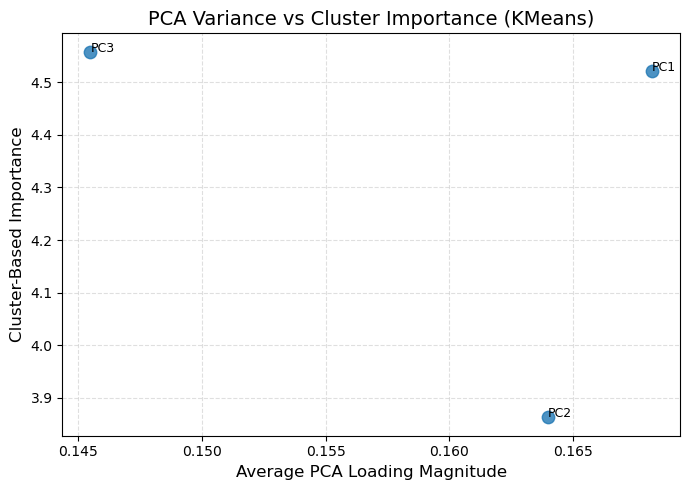

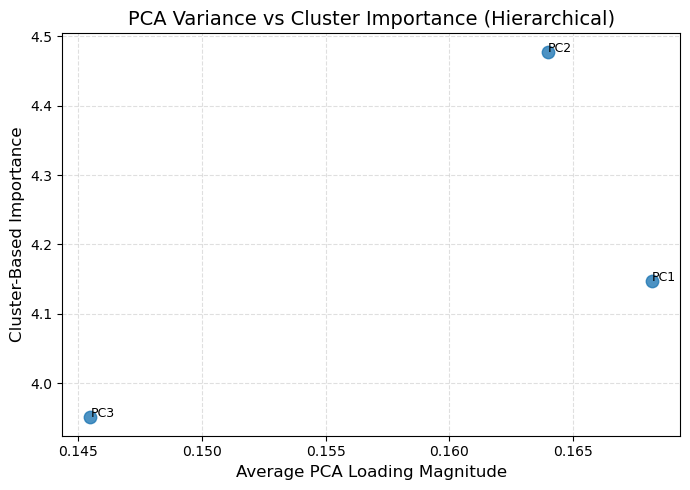

In [127]:
for name, df in comparison_tables.items():
    plt.figure(figsize=(7, 5))
    
    plt.scatter(
        df["Avg_Loading_Magnitude"],
        df["Cluster_Importance"],
        s=80,
        alpha=0.8
    )
    
    for pc in df.index:
        plt.text(
            df.loc[pc, "Avg_Loading_Magnitude"],
            df.loc[pc, "Cluster_Importance"],
            pc,
            fontsize=9
        )
    
    plt.xlabel("Average PCA Loading Magnitude", fontsize=12)
    plt.ylabel("Cluster-Based Importance", fontsize=12)
    plt.title(f"PCA Variance vs Cluster Importance ({name})", fontsize=14)
    
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


#### Insights

Both K-means and hierarchical clustering identified three clusters in the dataset; however, hierarchical clustering demonstrated superior cluster structure. It achieved a higher Silhouette Score (0.312 vs. 0.230) and a lower Davies–Bouldin Index (1.33 vs. 1.87), indicating improved cluster cohesion and separation. Although K-means produced a slightly higher Calinski–Harabasz Index (619.90 vs. 533.92), the overall internal validation metrics favored hierarchical clustering as the more robust method.

PCA loadings revealed that the first principal component (PC1) was dominated by size-related features (mean radius, mean perimeter, and mean area), representing a global morphological dimension. Subsequent components captured complementary characteristics, with texture and smoothness-related features contributing strongly to PC3 and PC4.

Despite comparable average loading magnitudes across the leading components, their relevance to clustering differed substantially. PC3 exhibited the highest cluster importance (4.56), marginally exceeding PC1 (4.52), while PC2 showed lower importance (3.86). This indicates that PC3 played a dominant role in cluster separation despite explaining less overall variance than PC1. The observed mismatch between variance contribution and clustering importance demonstrates that components capturing discriminative structure, rather than maximal variance, were primarily responsible for defining cluster boundaries.
